In [289]:
import string

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from wordcloud import STOPWORDS
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import emoji

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [290]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('../input/nlp-getting-started/test.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('\nTest Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB

Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


# 0. Constants

In [291]:
LOCATION_GROUPING_THRESHOLD = 3

# 1. EDA

## 1.1 Basic properties

In [292]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [293]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int16 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int8  
dtypes: int16(1), int8(1), object(3)
memory usage: 200.9+ KB


**Drop id column from dataframes. Save it separately for future submissions**

In [294]:
id_train=df_train['id']

id_test=df_test['id']

df_train.drop(columns='id',inplace=True)

df_test.drop(columns='id',inplace=True)

**Duplicates processing**  

In [295]:
df_train.duplicated().sum()

52

In [296]:
duplicates = df_train[df_train.duplicated(keep=False)]
duplicates

,keyword,location,text,target
40,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0
48,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0
106,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/zEVakJaPcz,0
115,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/zEVakJaPcz,0
118,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/THyzOMVWU0 | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/83jOO0xk29,0
...,...,...,...,...
6392,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
6434,suicide%20bombing,NaN,'Suicide bombing at [location named]...' #premonitions http://t.co/iIkSsJGBDn,1
6449,suicide%20bombing,NaN,'Suicide bombing at [location named]...' #premonitions http://t.co/iIkSsJGBDn,1
6652,terrorist,MAD as Hell,RT AbbsWinston: #Zionist #Terrorist kidnapped 15 #Palestinians in overnight terror on Palestinian Villages Û_ http://t.co/J5mKcbKcov,1


In [297]:
df_train = df_train.drop_duplicates()
df_train.duplicated().sum()

0

### **Statistical characteristics of data**

In [298]:
df_train.isna().sum()

keyword       61
location    2500
text           0
target         0
dtype: int64

In [299]:
df_test.isna().sum()

keyword       26
location    1105
text           0
dtype: int64

In [300]:
print('Percent of missing keyword in train data: {:.2f}%'.format(100 * df_train['keyword'].isna().mean()))
print('Percent of missing location in train data: {:.2f}%'.format(100 * df_train['location'].isna().mean()))
print('\nPercent of missing keyword in test data: {:.2f}%'.format(100 * df_test['keyword'].isna().mean()))
print('Percent of missing location in test data: {:.2f}%'.format(100 * df_test['location'].isna().mean()))

Percent of missing keyword in train data: 0.81%
Percent of missing location in train data: 33.06%

Percent of missing keyword in test data: 0.80%
Percent of missing location in test data: 33.86%


**We can conlcude, that missing values are distributed uniformly between df_train and df_test**

In [301]:
print('Number of unique keyword values in train data: {}'.format(df_train['keyword'].nunique()))
print('Number of unique location values in train data: {}'.format(df_train['location'].nunique()))
print('\nNumber of unique keyword values in test data: {}'.format(df_test['keyword'].nunique()))
print('Number of unique location values in test data: {}'.format(df_test['location'].nunique()))

Number of unique keyword values in train data: 221
Number of unique location values in train data: 3341

Number of unique keyword values in test data: 221
Number of unique location values in test data: 1602


In [302]:
for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

In [303]:
print('Number of disasters: {}'.format(df_train['target'].sum()))
print('Number of non-disasters: {}'.format(df_train['target'].count() - df_train['target'].sum()))

Number of disasters: 3239
Number of non-disasters: 4322


In [304]:
import plotly.express as px

target_counts = df_train['target'].value_counts().reset_index()
target_counts.columns = ['target', 'count']

fig = px.pie(target_counts, 
             values='count', 
             names='target',
             title='Target Distribution',
             color_discrete_sequence=px.colors.sequential.Rainbow)

fig.update_traces(textposition='inside', 
                  textinfo='percent+label',
                  pull=[0.1, 0, 0, 0],
                  marker=dict(line=dict(color='#000000', width=1)))

fig.update_layout(
    title_font_size=24,
    uniformtext_minsize=12,
    uniformtext_mode='hide',
    height=600,
    width=600
)

fig.show()

In [305]:
keyword_counts = df_train['keyword'].value_counts()
keyword_counts

keyword
no_keyword               61
fatalities               45
deluge                   42
armageddon               42
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 222, dtype: int64

In [306]:
location_counts = df_train['location'].value_counts()
location_counts

location
no_location                     2500
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
everydaynigerian@gmail.com         1
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
Lincoln                            1
Name: count, Length: 3342, dtype: int64

In [307]:
import plotly.express as px

df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

df_sorted = df_train.sort_values(by='target_mean', ascending=False)

fig = px.histogram(df_sorted, 
                   y='keyword',
                   color='target',
                   orientation='h',
                   height=3000,
                   width=800,
                   title='Target Distribution in Keywords',
                   color_discrete_sequence=px.colors.qualitative.Pastel)

fig.update_layout(
    yaxis=dict(autorange="reversed", tickfont=dict(size=10)),
    legend=dict(x=1, y=1),
    xaxis=dict(tickfont=dict(size=15))
)

df_train.drop(columns=['target_mean'], inplace=True)

fig.show()

## 1.2 Feature Engineering

In [308]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

# Sentiment
sid = SentimentIntensityAnalyzer()

df_train['vader_neg'] = df_train['text'].apply(lambda x: sid.polarity_scores(str(x))['neg'])
df_test['vader_neg'] = df_test['text'].apply(lambda x: sid.polarity_scores(str(x))['neg'])

df_train['vader_neu'] = df_train['text'].apply(lambda x: sid.polarity_scores(str(x))['neu'])
df_test['vader_neu'] = df_test['text'].apply(lambda x: sid.polarity_scores(str(x))['neu'])

df_train['vader_pos'] = df_train['text'].apply(lambda x: sid.polarity_scores(str(x))['pos'])
df_test['vader_pos'] = df_test['text'].apply(lambda x: sid.polarity_scores(str(x))['pos'])

df_train['vader_compound'] = df_train['text'].apply(lambda x: sid.polarity_scores(str(x))['compound'])
df_test['vader_compound'] = df_test['text'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

# Emoji count
df_train['emoji_count'] = df_train['text'].apply(lambda x: emoji.emoji_count(str(x)))
df_test['emoji_count'] = df_test['text'].apply(lambda x: emoji.emoji_count(str(x)))

# Capitalized words
df_train['caps_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper() and len(w)>1]))
df_test['caps_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper() and len(w)>1]))

# Exclamation marks
df_train['excl_count'] = df_train['text'].apply(lambda x: str(x).count('!'))
df_test['excl_count'] = df_test['text'].apply(lambda x: str(x).count('!'))

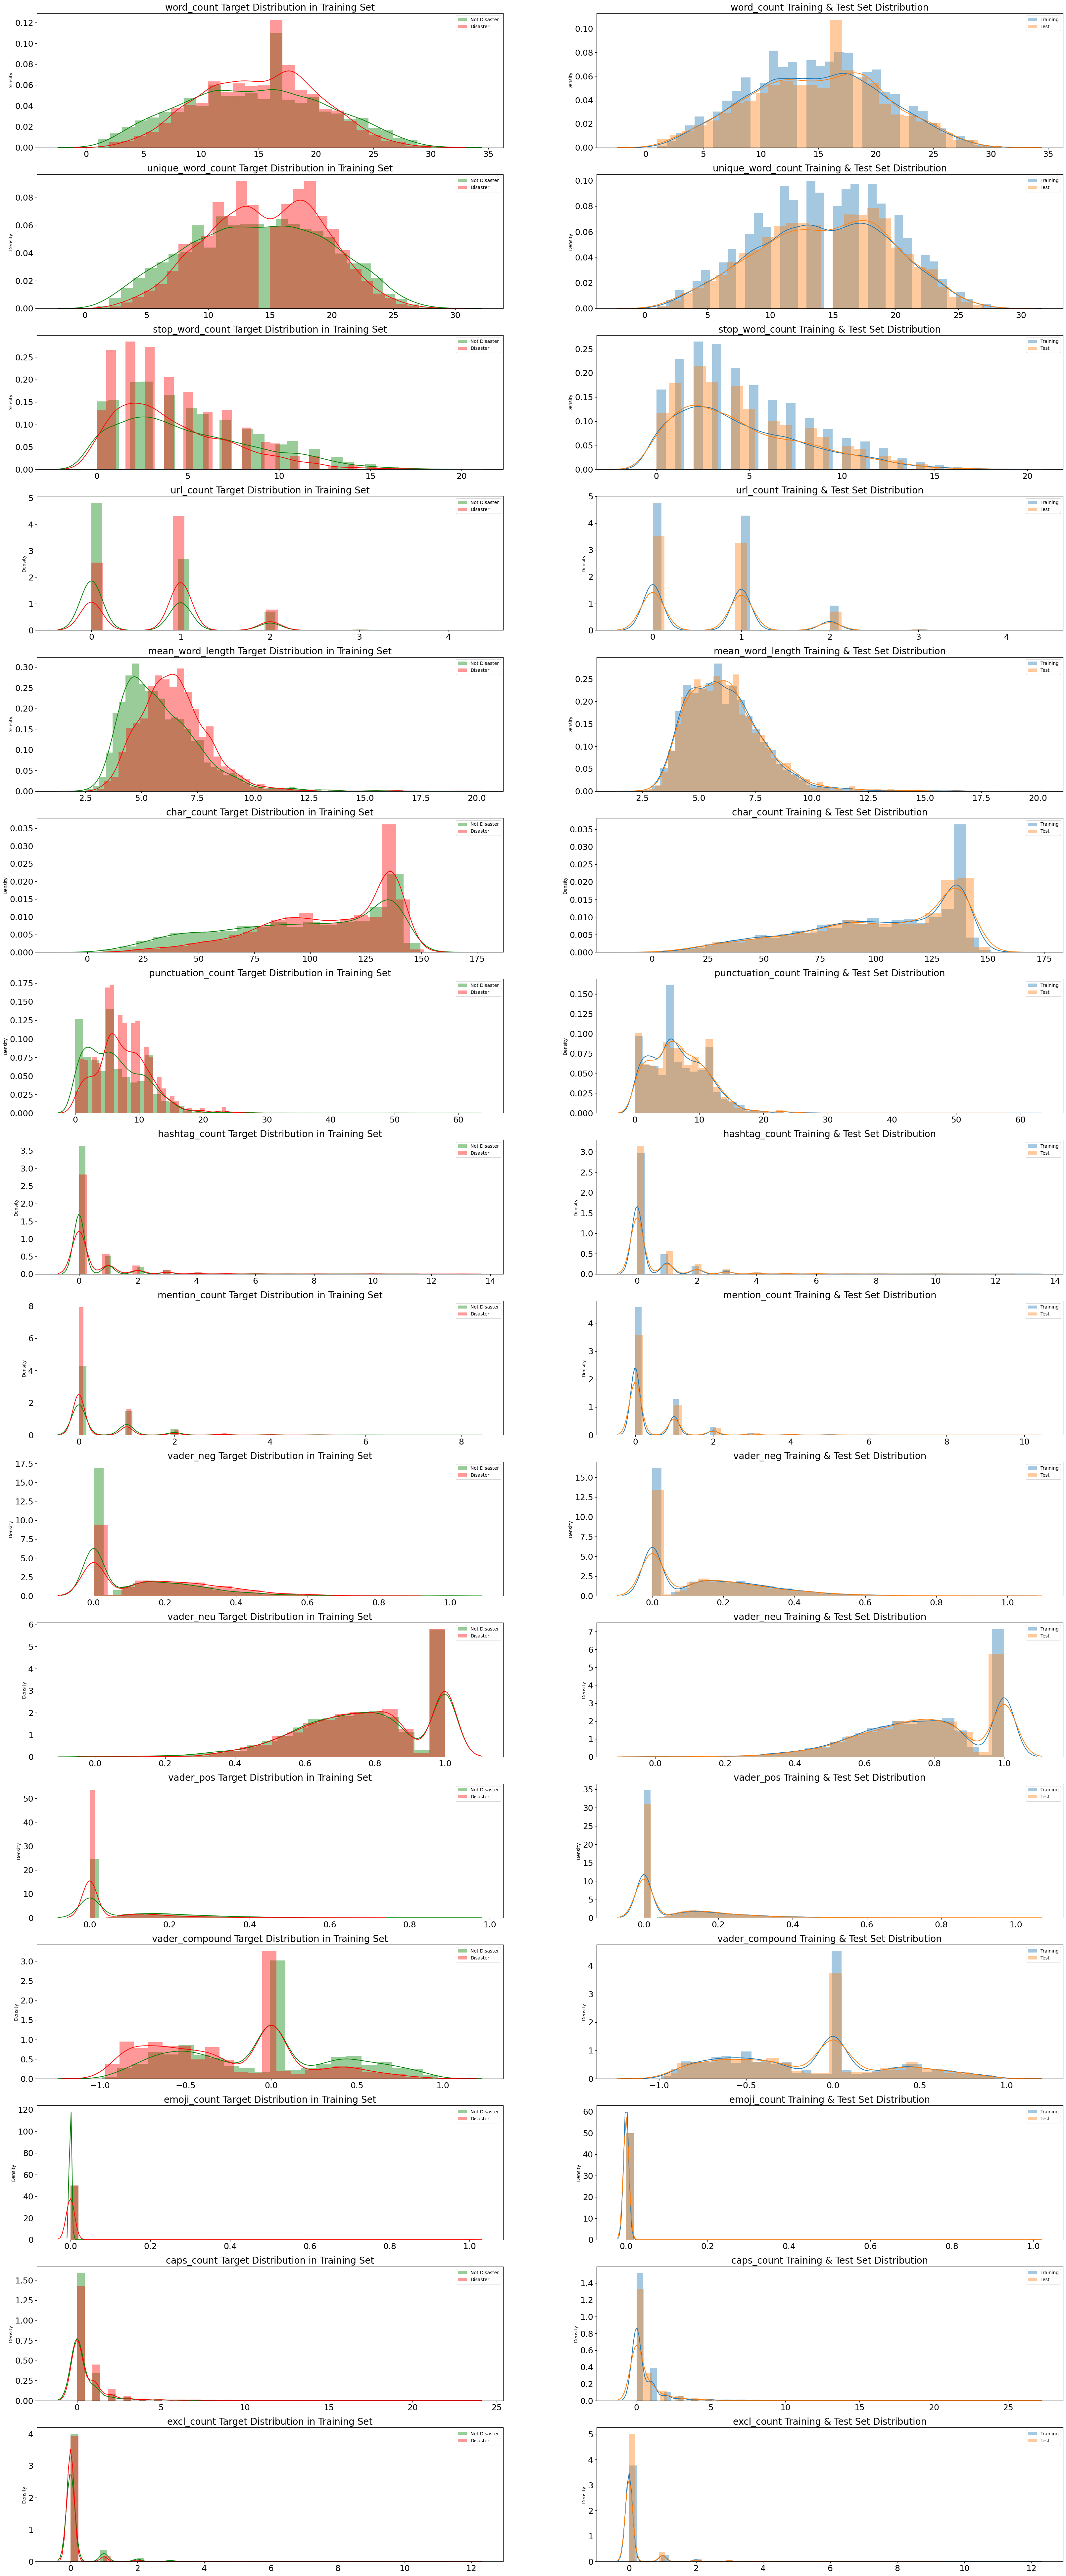

In [309]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 
                'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count',
                'mention_count', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
                'emoji_count', 'caps_count', 'excl_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(40, 100), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=18)
        axes[i][j].tick_params(axis='y', labelsize=18)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=20)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=20)

plt.show()

In [310]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correlation_matrix(df, features, target_col='target', figsize=(20, 12), 
                          cmap='mako', title='Correlation Matrix'):
    corr = df[features + [target_col]].corr(numeric_only=True)
    
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=figsize)
    
    sns.heatmap(corr, 
                annot=True, 
                mask=mask, 
                cmap=cmap, 
                fmt='.2f',
                vmin=-1, vmax=1,
                center=0,
                linewidths=.5)
    
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    plt.show()

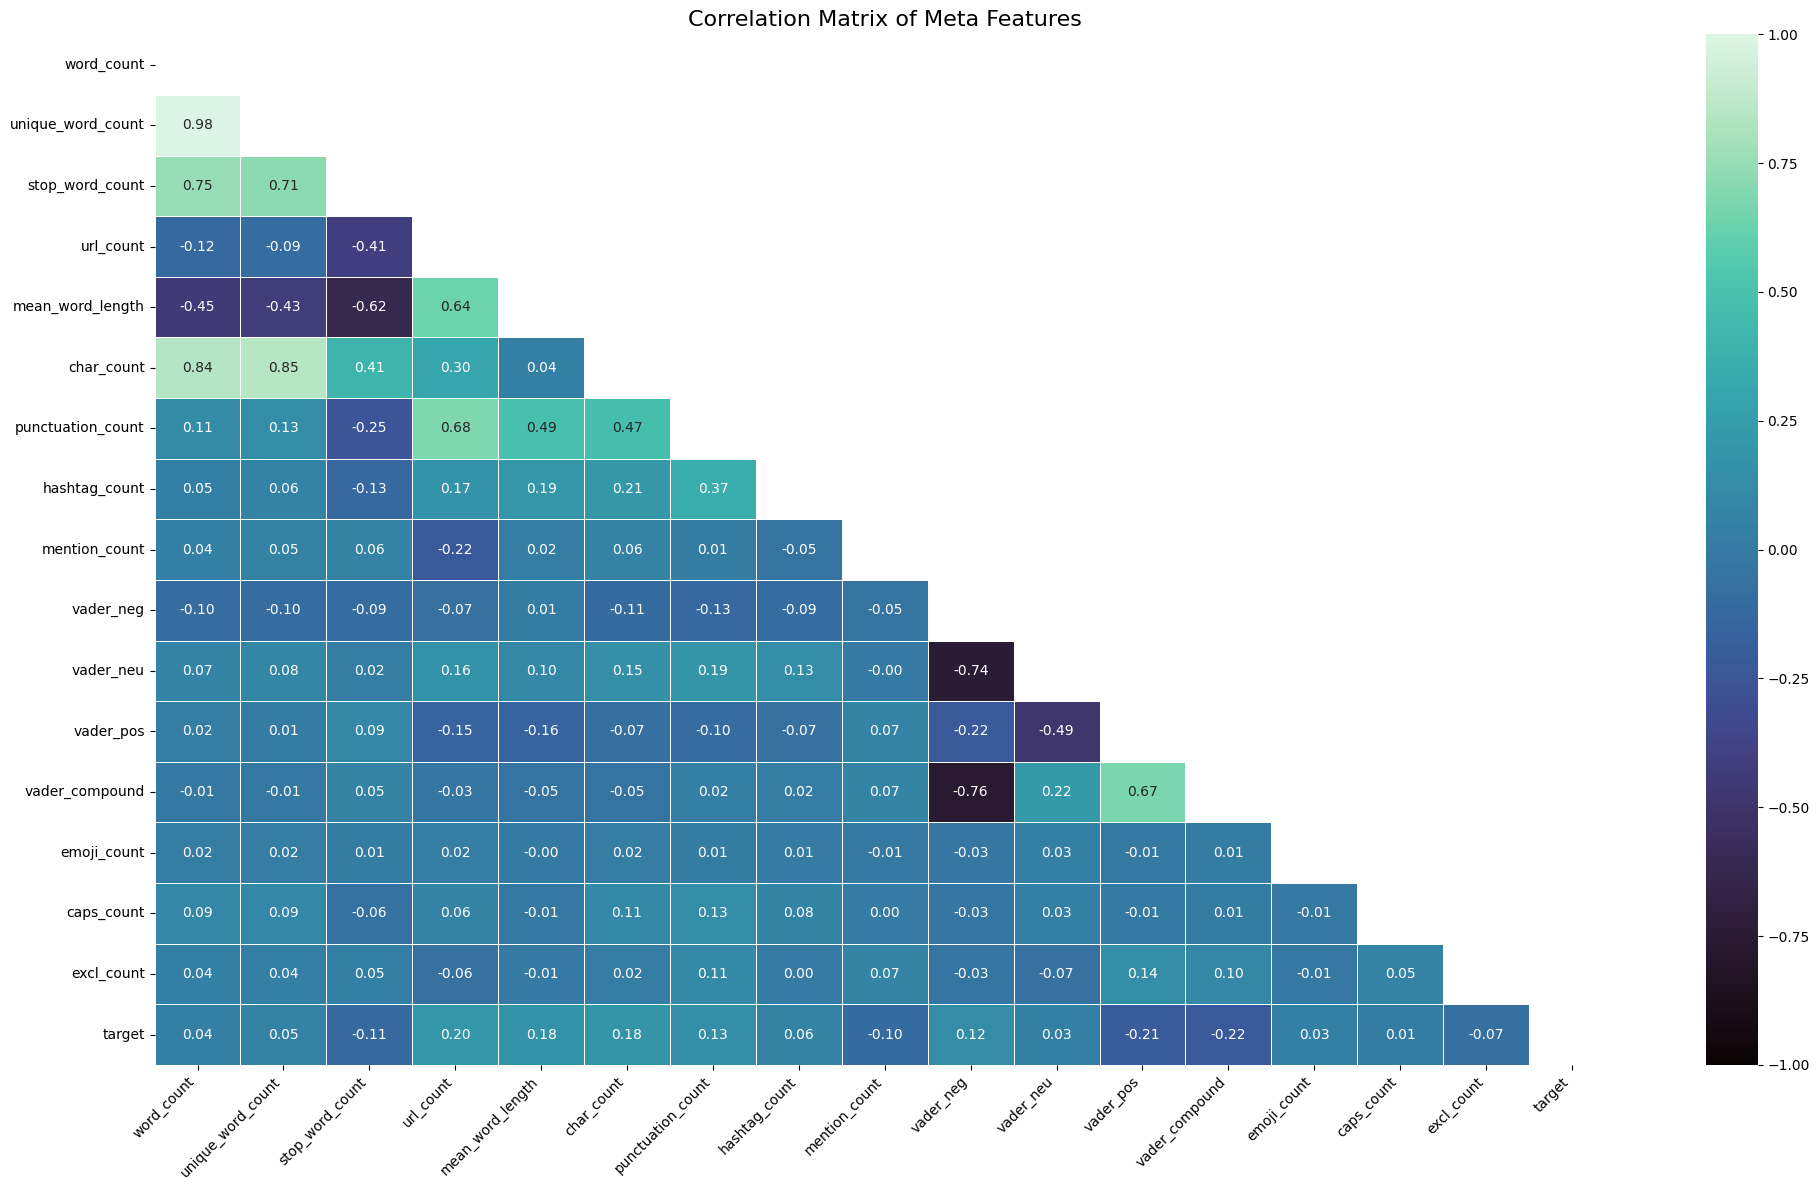

In [311]:
plot_correlation_matrix(
    df=df_train,
    features=METAFEATURES,
    title='Correlation Matrix of Meta Features'
)

***This type of correlation (Pearson coefficient) with binary target is unreliable!***

In [312]:
high_corr = corr.abs().stack().reset_index()
high_corr = high_corr[high_corr[0] > 0.9]
high_corr = high_corr[high_corr['level_0'] != high_corr['level_1']]
print("Highly correlated features:")
print(high_corr)

Highly correlated features:
Empty DataFrame
Columns: [level_0, level_1, 0]
Index: []


***Drop unique_word_count?***

## 1.3 Complex statistical feature selection

In [313]:
from sklearn.metrics import roc_auc_score
from scipy import stats

results = []
for feature in METAFEATURES:
    # Point-Biserial
    corr, pval_pb = stats.pointbiserialr(df_train[feature], df_train['target'])
    # ROC-AUC
    auc = roc_auc_score(df_train['target'], df_train[feature])
    # T-test
    group1 = df_train[df_train['target'] == 1][feature]
    group0 = df_train[df_train['target'] == 0][feature]
    t_stat, pval_tt = stats.ttest_ind(group1, group0)
    
    results.append({
        'feature': feature,
        'Point-Biserial': f"{corr:.3f} (p={pval_pb:.3g})",
        'ROC-AUC': f"{auc:.3f}",
        'T-test': f"t={t_stat:.3f} (p={pval_tt:.3g})"
    })

pd.DataFrame(results).set_index('feature')

,Point-Biserial,ROC-AUC,T-test
feature,,,
word_count,0.040 (p=0.000454),0.525,t=3.508 (p=0.000454)
unique_word_count,0.053 (p=3.65e-06),0.529,t=4.634 (p=3.65e-06)
stop_word_count,-0.110 (p=1.31e-21),0.446,t=-9.578 (p=1.31e-21)
url_count,0.198 (p=6.24e-68),0.618,t=17.593 (p=6.24e-68)
mean_word_length,0.176 (p=6.3e-54),0.630,t=15.585 (p=6.3e-54)
char_count,0.181 (p=7.29e-57),0.595,t=16.025 (p=7.29e-57)
punctuation_count,0.133 (p=4.08e-31),0.594,t=11.653 (p=4.08e-31)
hashtag_count,0.059 (p=2.54e-07),0.532,t=5.160 (p=2.54e-07)
mention_count,-0.102 (p=6.73e-19),0.447,t=-8.903 (p=6.73e-19)


### Instructions (look at the last section)


**'#' – not good, but keep for now**

**'##' – better drop?**

**'###' / '####' – drop!**


### **Analysis**

#### **p-value**
**High p-value (>0.001):**
- word_count
- unique_word_count
- stop_word_count
- url_count
- mean_word_length
- char_count
- punctuation_count
- hashtag_count
- mention_count
- vader_neg
- vader_neu (p=0.0058) #
- vader_pos
- vader_compound
- emoji_count (p=0.00256) #
- caps_count (p=0.296) #
- excl_count

##### **ROC AUC**
**Bad ROC AUC ([0.45, 0.55])**
- word_count (auc=0.525) #
- unique_word_count (auc=0.529) #
- stop_word_count
- url_count
- mean_word_length
- char_count
- punctuation_count
- hashtag_count (auc=0.532) #
- mention_count
- vader_neg
- vader_neu (auc=0.514) ##
- vader_pos
- vader_compound
- emoji_count (auc=0.501) ##
- caps_count (auc=0.536) ##
- excl_count (auc=0.470) #

#### **PBC**
**Low correlation ([-0.100, 0.100])**
- word_count (pbc=0.040) ##
- unique_word_count (pbc=0.053) ##
- stop_word_count
- url_count
- mean_word_length
- char_count
- punctuation_count
- hashtag_count (pbc=0.059) ##
- mention_count
- vader_neg
- vader_neu (pbc=0.032) ###
- vader_pos
- vader_compound
- emoji_count (pbc=0.035) ###
- caps_count (pbc=0.012) ###
- excl_count (pbc=-0.073) ##

#### **T-test**
**Low t-value ([-5.00, 5.00])**
- word_count (t=3.508) ###
- unique_word_count ###
- stop_word_count
- url_count
- mean_word_length
- char_count
- punctuation_count
- hashtag_count ##
- mention_count
- vader_neg
- vader_neu (t=2.760) ####
- vader_pos
- vader_compound
- emoji_count (t=3.017) ####
- caps_count ####
- excl_count ##

### Overall
- word_count ### (DROP)
- unique_word_count ### (DROP)
- stop_word_count
- url_count
- mean_word_length
- char_count
- punctuation_count
- hashtag_count ## (MAYBE DROP)
- mention_count
- vader_neg
- vader_neu #### (DROP)
- vader_pos
- vader_compound
- emoji_count #### (DROP)
- caps_count #### (DROP)
- excl_count ## (MAYBE DROP)


### Keep features:

- stop_word_count
- url_count
- mean_word_length
- char_count
- punctuation_count
- hashtag_count (???)
- mention_count
- vader_neg
- vader_pos
- vader_compound
- excl_count (???)


### VIF for remaining featrures

In [314]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

features_for_vif = [
    'stop_word_count', 'url_count', 'mean_word_length', 
    'char_count', 'punctuation_count', 'hashtag_count',
    'mention_count', 'vader_neg', 'vader_pos',
    'vader_compound', 'excl_count'
]

X = df_train[features_for_vif]
X_with_const = pd.DataFrame({'const': 1}, index=X.index).join(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) 
                   for i in range(X_with_const.shape[1])]

vif_data = vif_data[vif_data['feature'] != 'const'].sort_values("VIF", ascending=False)
print(vif_data)

              feature       VIF
10     vader_compound  6.762581
8           vader_neg  3.988497
2           url_count  3.154199
9           vader_pos  2.964964
5   punctuation_count  2.773381
1     stop_word_count  2.684158
3    mean_word_length  2.487291
4          char_count  2.344639
6       hashtag_count  1.228766
7       mention_count  1.202776
11         excl_count  1.078468


***Drop vader_compound?*** 

### VIF without vader_compound

In [315]:
features_for_vif = [
    'stop_word_count', 'url_count', 'mean_word_length', 
    'char_count', 'punctuation_count', 'hashtag_count',
    'mention_count', 'vader_neg', 'vader_pos', 'excl_count'
]

X = df_train[features_for_vif]
X_with_const = pd.DataFrame({'const': 1}, index=X.index).join(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) 
                   for i in range(X_with_const.shape[1])]

vif_data = vif_data[vif_data['feature'] != 'const'].sort_values("VIF", ascending=False)
print(vif_data)

              feature       VIF
2           url_count  3.154196
5   punctuation_count  2.770856
1     stop_word_count  2.678785
3    mean_word_length  2.468324
4          char_count  2.272374
6       hashtag_count  1.228677
7       mention_count  1.202674
9           vader_pos  1.116694
8           vader_neg  1.103656
10         excl_count  1.078459


In [316]:
FEATURES = [
    'stop_word_count', 'url_count', 'mean_word_length', 
    'char_count', 'punctuation_count', 'hashtag_count',
    'mention_count', 'vader_neg', 'vader_pos', 'excl_count'
]

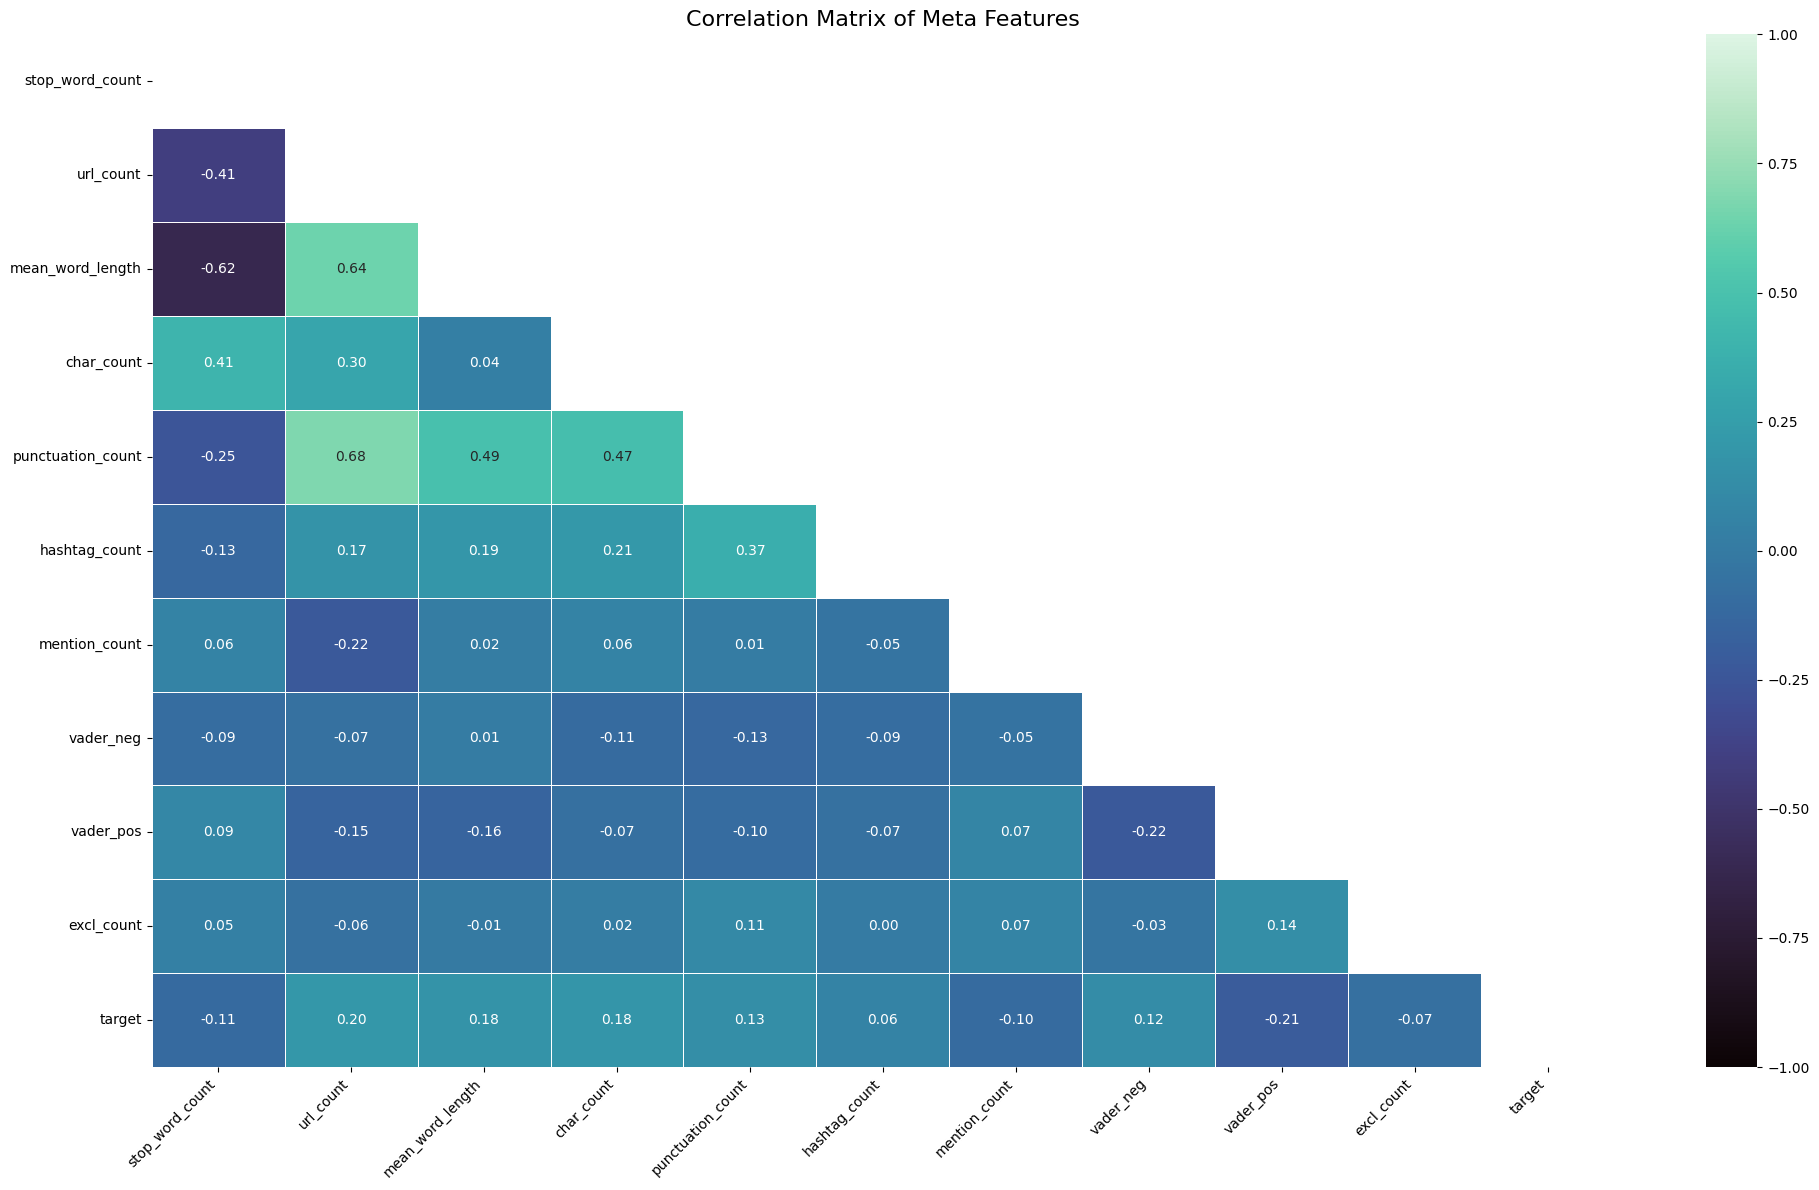

In [317]:
plot_correlation_matrix(
    df=df_train,
    features=FEATURES,
    title='Correlation Matrix of Meta Features'
)

In [318]:
METAFEATURES = [
    'word_count', 'unique_word_count', 'stop_word_count', 'url_count', 
    'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count',
    'mention_count', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
    'emoji_count', 'caps_count', 'excl_count'
]

FEATURES_STATS = [
    'stop_word_count', 'url_count', 'mean_word_length', 
    'char_count', 'punctuation_count', 'hashtag_count',
    'mention_count', 'vader_neg', 'vader_pos', 'excl_count'
]

## 1.4 Baseline with metafeatures

**Select features**

In [319]:
def prepare_feature_subsets(df_train, df_test, all_features, selected_features, target_col='target'):

    df_train_subset = df_train.filter(items=all_features + [target_col]).copy()
    df_test_subset = df_test.filter(items=all_features + [target_col]).copy()
    
    cols_to_drop = list(set(all_features) - set(selected_features))
    
    for df in [df_train_subset, df_test_subset]:
        drop_cols = [col for col in cols_to_drop if col in df.columns]
        df.drop(columns=drop_cols, inplace=True)
    
    print(f"Train columns: {df_train_subset.columns.tolist()}")
    print(f"Test columns: {df_test_subset.columns.tolist()}")
    
    return df_train_subset, df_test_subset

**Baseline model**

In [320]:
from catboost import CatBoostClassifier

def baseline_model(df_train, df_test, features, model_params=None, save_path=None):
    if model_params is None:
        model_params = {'random_state': 42, 'verbose': False}
    
    X_train = df_train[features]
    y_train = df_train['target']

    X_test = df_test[features]
    
    model = CatBoostClassifier(**model_params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    submission = pd.DataFrame({
        'id': id_test,
        'target': y_pred
    })
    
    if save_path is not None:
        submission.to_csv(save_path, index=False)
        print(f'Submission file saved to {save_path}')
    
    return submission

In [321]:
df_train_stats, df_test_stats = prepare_feature_subsets(
    df_train=df_train,
    df_test=df_test,
    all_features=METAFEATURES,
    selected_features=FEATURES_STATS
)

Train columns: ['stop_word_count', 'url_count', 'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count', 'vader_neg', 'vader_pos', 'excl_count', 'target']
Test columns: ['stop_word_count', 'url_count', 'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count', 'vader_neg', 'vader_pos', 'excl_count']


In [322]:
submission = baseline_model(
    df_train=df_train_stats,
    df_test=df_test_stats,
    features=FEATURES_STATS,
    model_params={'random_state': 42, 'iterations': 500, 'verbose': False},
    save_path='submission_stats.csv'
)

Submission file saved to submission_stats.csv


### F1 score for baseline model (metafeatures-only)

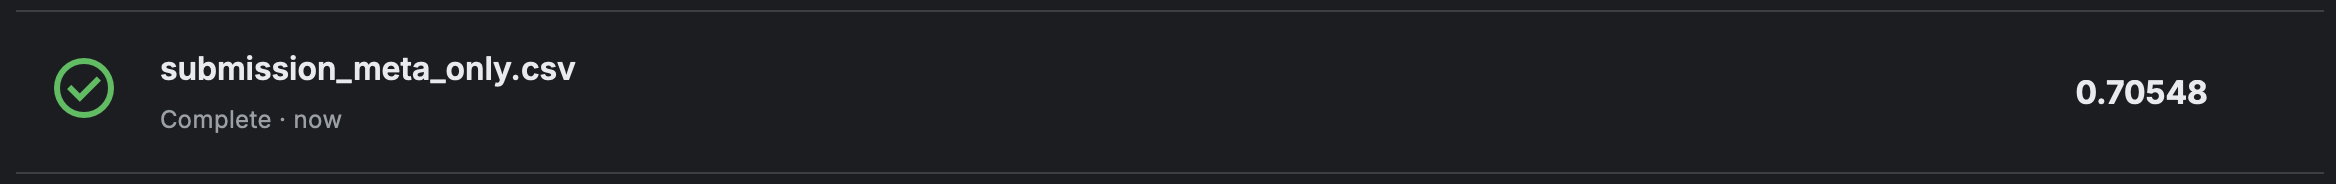

## 1.5 Keyword and Location features


In [323]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df_train['keyword'], df_train['target'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"χ² = {chi2:.1f}, p-value = {p:.4f}")

contingency_table = pd.crosstab(df_train['location'], df_train['target'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"χ² = {chi2:.1f}, p-value = {p:.4f}")

χ² = 2253.8, p-value = 0.0000
χ² = 3517.2, p-value = 0.0167


**Both keyword and location show p-value < 0.05 what indicates their significance**

In [324]:
print(df_train['keyword'].nunique())
print(df_train['location'].nunique())


222
3342


**However, right now the number of unique values in location column makes this result unreliable**

Since 'location' is a user-input column, it's highly possible that unique values are not real geographical objects but some other non-informative(?) mess. And if a specific value occurs several times it's likely to be a real place (the chance for many people to write the same sequence of symbols not connected to real location is very little)

In [325]:
loc_counts = df_train['location'].value_counts()
df_train['location_grouped'] = df_train['location'].apply(
    lambda x: x if loc_counts[x] > LOCATION_GROUPING_THRESHOLD else 'other'
)

df_train['location_grouped'].nunique()

155

In [326]:
contingency_table = pd.crosstab(df_train['location_grouped'], df_train['target'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"χ² = {chi2:.1f}, p-value = {p:.4f}")

χ² = 317.1, p-value = 0.0000


In [327]:
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

encoder_keyword = TargetEncoder(smoothing=0.3)
df_train['keyword_encoded'] = encoder_keyword.fit_transform(
    df_train[['keyword']], 
    df_train['target']
)

model_keyword = RandomForestClassifier(n_estimators=100, random_state=42)
model_keyword.fit(df_train[['keyword_encoded']], df_train['target'])

result_keyword = permutation_importance(
    model_keyword, 
    df_train[['keyword_encoded']], 
    df_train['target'], 
    n_repeats=5,
    random_state=42
)

print(f"Keyword Importance: {result_keyword.importances_mean[0]:.4f} (±{result_keyword.importances_std[0]:.4f})")

Keyword Importance: 0.2316 (±0.0074)


In [328]:
from category_encoders import TargetEncoder
from sklearn.inspection import permutation_importance

encoder = TargetEncoder(smoothing=0.3)
df_train['location_encoded'] = encoder.fit_transform(
    df_train[['location_grouped']], 
    df_train['target']
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(df_train[['location_encoded']], df_train['target'])

result = permutation_importance(
    model, 
    df_train[['location_encoded']], 
    df_train['target'], 
    n_repeats=5,
    random_state=42
)

print(f"Location Importance: {result.importances_mean[0]:.4f} (±{result.importances_std[0]:.4f})")

Location Importance: 0.0196 (±0.0026)


## 1.6 Feature selection with Boruta

In [329]:
import pandas as pd
import numpy as np
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


X = df_train_copy[METAFEATURES].copy()
y = df_train['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [330]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=7,
    class_weight='balanced',
    random_state=42
)

boruta = BorutaPy(
    estimator=rf,
    n_estimators='auto',
    alpha=0.05,
    max_iter=50,
    verbose=0,
    random_state=42
)

In [331]:
X_array = X_scaled.values

boruta.fit(X_array, y.values)

selected_mask = boruta.support_
tentative_mask = boruta.support_weak_
rejected_mask = ~(selected_mask | tentative_mask)

selected_features = X.columns[selected_mask].tolist()
tentative_features = X.columns[tentative_mask].tolist()
rejected_features = X.columns[rejected_mask].tolist()

print(f"Selected features ({len(selected_features)}):", selected_features)
print(f"Tentative features ({len(tentative_features)}):", tentative_features)
print(f"Rejected features ({len(rejected_features)}):", rejected_features)

Selected features (12): ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length', 'char_count', 'punctuation_count', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'excl_count']
Tentative features (1): ['mention_count']
Rejected features (3): ['hashtag_count', 'emoji_count', 'caps_count']


In [332]:
FEATURES_BORUTA = [
    'word_count','unique_word_count', 'stop_word_count', 'url_count',
    'mean_word_length', 'char_count', 'punctuation_count','vader_neg',
    'vader_neu', 'vader_pos','vader_compound', 'excl_count'
]

In [333]:
df_train_boruta, df_test_boruta = prepare_feature_subsets(
    df_train=df_train,
    df_test=df_test,
    all_features=METAFEATURES,
    selected_features=FEATURES_BORUTA
)

Train columns: ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length', 'char_count', 'punctuation_count', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'excl_count', 'target']
Test columns: ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length', 'char_count', 'punctuation_count', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'excl_count']


In [334]:
submission = baseline_model(
    df_train=df_train_boruta,
    df_test=df_test_boruta,
    features=FEATURES_BORUTA,
    model_params={'random_state': 42, 'iterations': 500, 'verbose': False},
    save_path='submission_boruta.csv'
)

Submission file saved to submission_boruta.csv


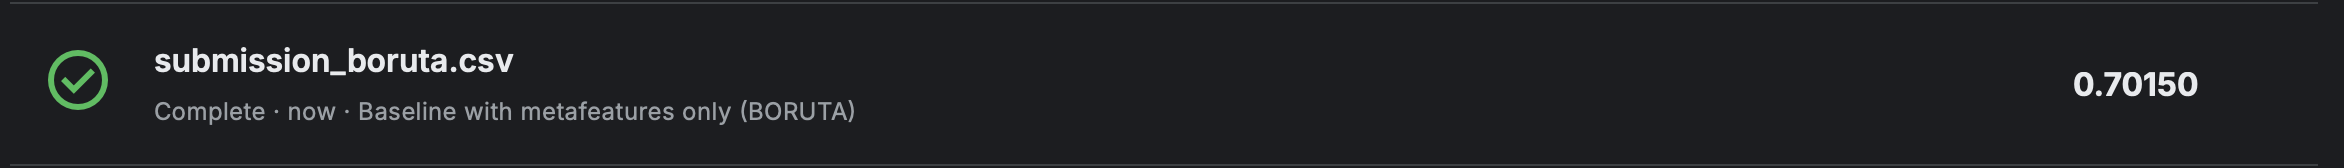

## 1.7 Feature selection with SHAP

2025-05-13 19:55:27.275263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747166127.494875      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747166127.552251      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


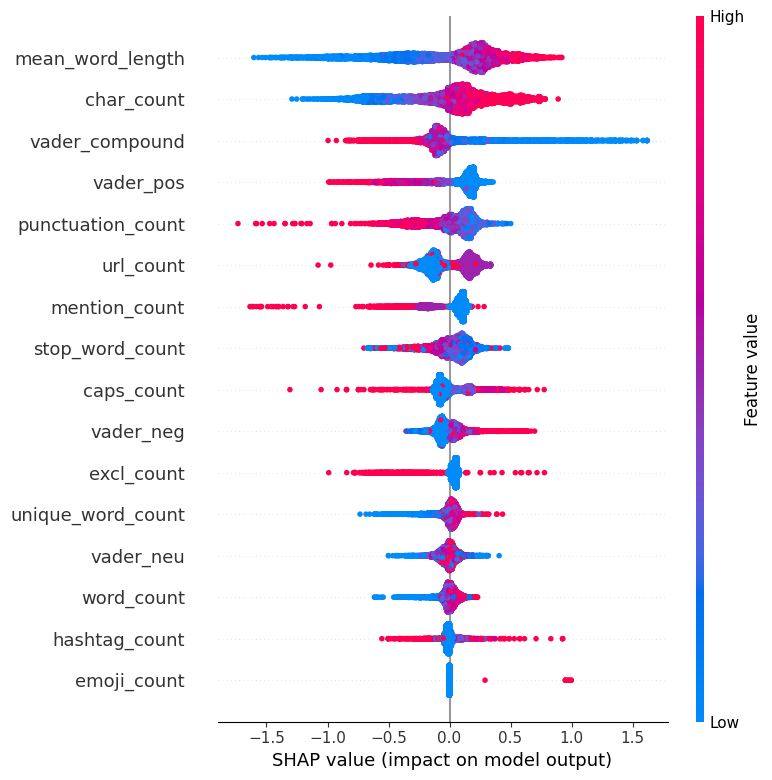

In [335]:
import shap

model = CatBoostClassifier(random_state=42, verbose=False)

X = df_train_copy[METAFEATURES]
y = df_train['target']

shap.initjs()
model.fit(X, y)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [336]:
FEATURES_SHAP = [
    'mean_word_length', 'char_count', 'vader_compound', 'vader_pos',
    'punctuation_count', 'url_count', 'mention_count', 'stop_word_count',
    'caps_count', 'vader_neg'
]

In [337]:
df_train_shap, df_test_shap = prepare_feature_subsets(
    df_train=df_train,
    df_test=df_test,
    all_features=METAFEATURES,
    selected_features=FEATURES_SHAP
)

Train columns: ['stop_word_count', 'url_count', 'mean_word_length', 'char_count', 'punctuation_count', 'mention_count', 'vader_neg', 'vader_pos', 'vader_compound', 'caps_count', 'target']
Test columns: ['stop_word_count', 'url_count', 'mean_word_length', 'char_count', 'punctuation_count', 'mention_count', 'vader_neg', 'vader_pos', 'vader_compound', 'caps_count']


In [338]:
submission = baseline_model(
    df_train=df_train_shap,
    df_test=df_test_shap,
    features=FEATURES_SHAP,
    model_params={'random_state': 42, 'iterations': 500, 'verbose': False},
    save_path='submission_shap.csv'
)

Submission file saved to submission_shap.csv


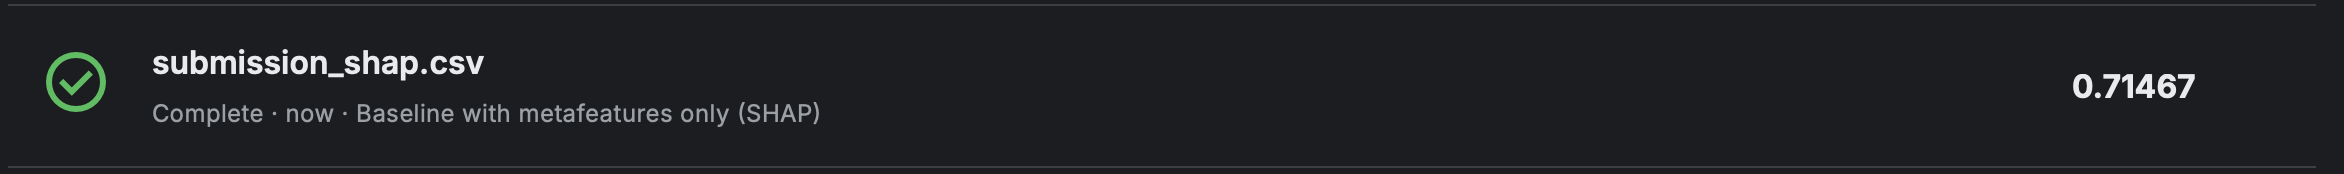

### Overall

- **Statistical tests prescribe to drop:**
    - word_count
    - unique_word_count
    - vader_neu
    - emoji_count
    - caps_count
    - Tentative features:
        - hashtag_count
        - excl_count
        - vader_compound
---

- **Boruta prescribes to drop:**
    - hashtag_count
    - emoji_count
    - caps_count
    - Tentative features:
        - mention_count
     
---

- **SHAP analysis prescribes to drop:**
    - emoji_count
    - hashtag_count
    - word_count
    - vader_neu
    - unique_word_count
    - Tentative features:
        - excl_count


**Best F1 score shows the subset of metafeatures derived from SHAP analysis**

# 2. Text processing

## 2.1 Cleaning and Tokenization pipeline

In [339]:
import re
import string
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer
from transformers import BertTokenizer, GPT2Tokenizer, XLNetTokenizer
from tokenizers import Tokenizer, models, pre_tokenizers, decoders
from tokenizers.models import BPE, WordPiece, Unigram
from tokenizers.trainers import BpeTrainer, WordPieceTrainer, UnigramTrainer
from tokenizers.pre_tokenizers import Whitespace
import os

try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tweet_tokenizer = TweetTokenizer()

bert_tokenizer = None
gpt2_tokenizer = None
xlnet_tokenizer = None

def load_bert_tokenizer():
    global bert_tokenizer
    if bert_tokenizer is None:
        bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    return bert_tokenizer

def load_gpt2_tokenizer():
    global gpt2_tokenizer
    if gpt2_tokenizer is None:
        gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    return gpt2_tokenizer

def load_xlnet_tokenizer():
    global xlnet_tokenizer
    if xlnet_tokenizer is None:
        xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
    return xlnet_tokenizer

def create_bpe_tokenizer(vocab_size=30000):
    tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    tokenizer.decoder = decoders.ByteLevel()
    return tokenizer

def create_wordpiece_tokenizer(vocab_size=30000):
    tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    return tokenizer

def create_unigram_tokenizer(vocab_size=30000):
    tokenizer = Tokenizer(Unigram())
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    return tokenizer

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text)

def remove_mentions(text):
    mention_pattern = re.compile(r'@\w+')
    return mention_pattern.sub('', text)

def remove_hashtags(text):
    hashtag_pattern = re.compile(r'#\w+')
    return hashtag_pattern.sub('', text)

def remove_emojis(text):
    return emoji.replace_emoji(text, '')

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_extra_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop_words]

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

def stem_tokens(tokens):
    from nltk.stem.porter import PorterStemmer
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

def basic_clean(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = remove_urls(text)
    text = remove_mentions(text)
    text = remove_hashtags(text)
    text = remove_emojis(text)
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = remove_extra_whitespace(text)
    
    return text

def tokenize_text(text, tokenizer_type='word'):

    if tokenizer_type == 'word':
        return word_tokenize(text)
    elif tokenizer_type == 'tweet':
        return tweet_tokenizer.tokenize(text)
    elif tokenizer_type == 'sentence':
        return sent_tokenize(text)
    elif tokenizer_type == 'bert':
        tokenizer = load_bert_tokenizer()
        return tokenizer.tokenize(text)
    elif tokenizer_type == 'gpt2':
        tokenizer = load_gpt2_tokenizer()
        return tokenizer.tokenize(text)
    elif tokenizer_type == 'xlnet':
        tokenizer = load_xlnet_tokenizer()
        return tokenizer.tokenize(text)
    elif tokenizer_type == 'bpe':
        # GPT-2 tokenizer (BPE)
        tokenizer = load_gpt2_tokenizer()
        return tokenizer.tokenize(text)
    elif tokenizer_type == 'wordpiece':
        # BERT tokenizer (WordPiece)
        tokenizer = load_bert_tokenizer()
        return tokenizer.tokenize(text)
    elif tokenizer_type == 'unigram':
        # XLNet (Unigram)
        tokenizer = load_xlnet_tokenizer()
        return tokenizer.tokenize(text)
    else:
        raise ValueError(f"Unknown tokenizer: {tokenizer_type}")

def advanced_clean(text, tokenizer_type='word', remove_stop=True, lemmatize=True, stem=False):

    text = basic_clean(text)
    
    if tokenizer_type in ['bert', 'gpt2', 'xlnet', 'bpe', 'wordpiece', 'unigram']:
        text = text.lower()
        text = remove_urls(text)
        text = remove_mentions(text)
        text = remove_hashtags(text)
        text = remove_emojis(text)
        text = remove_extra_whitespace(text)
    
    tokens = tokenize_text(text, tokenizer_type)
    
    if tokenizer_type in ['bert', 'gpt2', 'xlnet', 'bpe', 'wordpiece', 'unigram']:
        return ' '.join(tokens)
    
    if remove_stop:
        tokens = remove_stopwords(tokens)
    
    if lemmatize:
        tokens = lemmatize_tokens(tokens)
    
    if stem:
        tokens = stem_tokens(tokens)
    
    return ' '.join(tokens)

def clean_dataframe(df, text_column='text', new_column='cleaned_text', method='basic', 
                   tokenizer_type='word', remove_stop=True, lemmatize=True, stem=False):
    if method == 'basic':
        df[new_column] = df[text_column].apply(basic_clean)
    else:
        df[new_column] = df[text_column].apply(
            lambda x: advanced_clean(x, tokenizer_type=tokenizer_type, 
                                    remove_stop=remove_stop, 
                                    lemmatize=lemmatize, 
                                    stem=stem)
        )
    
    return df

TOKENIZATION_METHODS = [
    'word',       # standard word tokenization (NLTK)
    'tweet',      # tweet tokenization (NLTK)
    'sentence',   # sentence tokenization (NLTK)
    'bpe',        # Byte-Pair Encoding
    'wordpiece',  # WordPiece
    'unigram',    # Unigram
    'bert',       # Bert tokenization
    'gpt2',       # GPT-2 tokenization
    'xlnet'       # XLNet tokenization
]

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [340]:
df_train_copy = df_train

In [341]:
df_train.head()

,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,...,vader_neg,vader_neu,vader_pos,vader_compound,emoji_count,caps_count,excl_count,location_grouped,keyword_encoded,location_encoded
0,no_keyword,no_location,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,13,13,6,0,4.384615,69,...,0.000,0.851,0.149,0.2732,0,1,0,no_location,0.688525,0.422
1,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,7,7,0,0,4.571429,38,...,0.286,0.714,0.000,-0.3400,0,0,0,no_location,0.688525,0.422
2,no_keyword,no_location,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,22,20,11,0,5.090909,133,...,0.095,0.905,0.000,-0.2960,0,0,0,no_location,0.688525,0.422
3,no_keyword,no_location,"13,000 people receive #wildfires evacuation orders in California",1,8,8,1,0,7.125000,65,...,0.000,1.000,0.000,0.0000,0,0,0,no_location,0.688525,0.422
4,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,16,15,7,0,4.500000,88,...,0.000,1.000,0.000,0.0000,0,0,0,no_location,0.688525,0.422


In [342]:
to_drop = list(set(METAFEATURES) - set(FEATURES_SHAP))

cols_to_drop = [col for col in to_drop if col in df_train.columns]
df_train.drop(columns=cols_to_drop, inplace=True)

In [343]:
df_train.drop(columns=['keyword','location','location_grouped'], inplace=True)

In [344]:
df_train

,text,target,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,mention_count,vader_neg,vader_pos,vader_compound,caps_count,keyword_encoded,location_encoded
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,6,0,4.384615,69,1,0,0.000,0.149,0.2732,1,0.688525,0.422
1,Forest fire near La Ronge Sask. Canada,1,0,0,4.571429,38,1,0,0.286,0.000,-0.3400,0,0.688525,0.422
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,11,0,5.090909,133,3,0,0.095,0.000,-0.2960,0,0.688525,0.422
3,"13,000 people receive #wildfires evacuation orders in California",1,1,0,7.125000,65,2,0,0.000,0.000,0.0000,0,0.688525,0.422
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,7,0,4.500000,88,2,0,0.000,0.000,0.0000,0,0.688525,0.422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,2,1,6.636364,83,5,0,0.262,0.000,-0.4939,0,0.688525,0.422
7609,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,9,0,5.300000,125,5,2,0.166,0.000,-0.5849,0,0.688525,0.422
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,1,1,7.250000,65,11,0,0.000,0.000,0.0000,1,0.688525,0.422
7611,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,5,0,6.263158,137,5,0,0.345,0.000,-0.7845,0,0.688525,0.422


In [345]:
from functools import partial

df_train_basic = df_train.copy()
df_train_word = df_train.copy()
df_train_tweet = df_train.copy()
df_train_bert = df_train.copy()
df_train_gpt2 = df_train.copy()
df_train_xlnet = df_train.copy()
df_train_bpe = df_train.copy()
df_train_wordpiece = df_train.copy()
df_train_unigram = df_train.copy()

def safe_tokenize(text, tokenizer_func):
    try:
        return tokenizer_func(text)
    except Exception as e:
        print(f"Error processing text: {text[:50]}... Error: {str(e)}")
        return ""

methods = {
    'basic': partial(advanced_clean, tokenizer_type='word', remove_stop=False, lemmatize=False),
    'word': partial(advanced_clean, tokenizer_type='word', remove_stop=True, lemmatize=True),
    'tweet': partial(advanced_clean, tokenizer_type='tweet', remove_stop=True, lemmatize=True),
    'bert': partial(advanced_clean, tokenizer_type='bert'),
    'gpt2': partial(advanced_clean, tokenizer_type='gpt2'),
    'xlnet': partial(advanced_clean, tokenizer_type='xlnet'),
    'bpe': partial(advanced_clean, tokenizer_type='bpe'),
    'wordpiece': partial(advanced_clean, tokenizer_type='wordpiece'),
    'unigram': partial(advanced_clean, tokenizer_type='unigram')
}

dfs = {}
for name, method in methods.items():
    df = df_train.copy()
    df[f'cleaned_text_{name}'] = df['text'].apply(lambda x: safe_tokenize(x, method))
    dfs[name] = df
    print(f"Processed {name} tokenization")

df_train_basic = dfs['basic']
df_train_word = dfs['word']
df_train_tweet = dfs['tweet']
df_train_bpe = dfs['bpe']
df_train_wordpiece = dfs['wordpiece']
df_train_unigram = dfs['unigram']
df_train_bert = dfs['bert']
df_train_gpt2 = dfs['gpt2']
df_train_xlnet = dfs['xlnet']

sample_idx = 0
for name, df in dfs.items():
    print(f"\n--- {name} tokenization ---")
    print("Original:", df['text'].iloc[sample_idx][:100], "...")
    print("Cleaned:", df[f'cleaned_text_{name}'].iloc[sample_idx][:100], "...")

Processed basic tokenization
Processed word tokenization
Processed tweet tokenization
Processed bert tokenization
Processed gpt2 tokenization
Processed xlnet tokenization
Processed bpe tokenization
Processed wordpiece tokenization
Processed unigram tokenization

--- basic tokenization ---
Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all ...
Cleaned: our deeds are the reason of this may allah forgive us all ...

--- word tokenization ---
Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all ...
Cleaned: deed reason may allah forgive u ...

--- tweet tokenization ---
Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all ...
Cleaned: deed reason may allah forgive u ...

--- bert tokenization ---
Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all ...
Cleaned: our deeds are the reason of this may allah forgive us all ...

--- gpt2 tokenization ---
Original: Our Deeds are the Reaso

In [346]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
from scipy.sparse import csr_matrix
from collections import defaultdict

class TextVectorizer:
    def __init__(self, method='tfidf', **kwargs):

        self.method = method
        self.params = kwargs
        self.vectorizer = None
        self.embedding_model = None
        self.vocab = None
        
    def fit(self, texts):
        if isinstance(texts.iloc[0], str):
            tokenized_texts = [text.split() for text in texts]
        else:
            tokenized_texts = texts.tolist()
            
        if self.method == 'bow':
            self.vectorizer = CountVectorizer(**self.params)
            self.vectorizer.fit([' '.join(tokens) for tokens in tokenized_texts])
            
        elif self.method == 'tfidf':
            self.vectorizer = TfidfVectorizer(**self.params)
            self.vectorizer.fit([' '.join(tokens) for tokens in tokenized_texts])
            
        elif self.method == 'ppmi':
            self._fit_ppmi(tokenized_texts)
            
        elif self.method == 'word2vec':
            self.embedding_model = Word2Vec(
                sentences=tokenized_texts,
                vector_size=self.params.get('vector_size', 100),
                window=self.params.get('window', 5),
                min_count=self.params.get('min_count', 5),
                workers=self.params.get('workers', 4),
                sg=self.params.get('sg', 0),  # 0 for CBOW, 1 for skip-gram
                **{k: v for k, v in self.params.items() 
                   if k not in ['vector_size', 'window', 'min_count', 'workers', 'sg']}
            )
            
        else:
            raise ValueError(f"Unknown vectorization method: {self.method}")
            
        return self
    
    def transform(self, texts):
        if isinstance(texts.iloc[0], str):
            tokenized_texts = [text.split() for text in texts]
        else:
            tokenized_texts = texts.tolist()
            
        if self.method == 'bow':
            return self.vectorizer.transform([' '.join(tokens) for tokens in tokenized_texts])
            
        elif self.method == 'tfidf':
            return self.vectorizer.transform([' '.join(tokens) for tokens in tokenized_texts])
            
        elif self.method == 'ppmi':
            return self._transform_ppmi(tokenized_texts)
            
        elif self.method == 'word2vec':
            return np.array([self._get_avg_embedding(tokens) for tokens in tokenized_texts])
            
        else:
            raise ValueError(f"Unknown vectorization method: {self.method}")
    
    def _fit_ppmi(self, tokenized_texts):
        self.dictionary = Dictionary(tokenized_texts)
        
        window_size = self.params.get('window_size', 5)
        cooccurrence = defaultdict(lambda: defaultdict(int))
        total_words = 0
        
        for doc in tokenized_texts:
            for i, target_word in enumerate(doc):
                if target_word not in self.dictionary.token2id:
                    continue
                target_id = self.dictionary.token2id[target_word]
                
                start = max(0, i - window_size)
                end = min(len(doc), i + window_size + 1)
                
                for j in range(start, end):
                    if j == i:
                        continue
                    context_word = doc[j]
                    if context_word not in self.dictionary.token2id:
                        continue
                    context_id = self.dictionary.token2id[context_word]
                    cooccurrence[target_id][context_id] += 1
                total_words += 1
                
        rows, cols, data = [], [], []
        for target_id, contexts in cooccurrence.items():
            for context_id, count in contexts.items():
                rows.append(target_id)
                cols.append(context_id)
                data.append(count)
                
        cooccurrence_matrix = csr_matrix(
            (data, (rows, cols)), 
            shape=(len(self.dictionary), len(self.dictionary)))
            
        total_cooccurrences = cooccurrence_matrix.sum()
        word_freqs = np.array(cooccurrence_matrix.sum(axis=1)).flatten()
        
        pmi_data = []
        rows, cols = cooccurrence_matrix.nonzero()
        
        for i, j in zip(rows, cols):
            p_xy = cooccurrence_matrix[i,j] / total_cooccurrences
            p_x = word_freqs[i] / total_cooccurrences
            p_y = word_freqs[j] / total_cooccurrences
            pmi = np.log(p_xy / (p_x * p_y))
            pmi_data.append(max(0, pmi))
            
        self.ppmi_matrix = csr_matrix(
            (pmi_data, (rows, cols)), 
            shape=cooccurrence_matrix.shape)
            
    def _transform_ppmi(self, tokenized_texts):
        corpus = [self.dictionary.doc2bow(text) for text in tokenized_texts]
        
        vectors = []
        for doc in corpus:
            if not doc:
                vectors.append(np.zeros(len(self.dictionary)))
                continue
                
            doc_vector = np.zeros(len(self.dictionary))
            for word_id, count in doc:
                doc_vector += self.ppmi_matrix[word_id].toarray().flatten() * count
                
            vectors.append(doc_vector)
            
        return np.array(vectors)
        
    def _get_avg_embedding(self, tokens):
        if not tokens:
            return np.zeros(self.embedding_model.vector_size)
            
        vectors = []
        for token in tokens:
            if token in self.embedding_model.wv:
                vectors.append(self.embedding_model.wv[token])
                
        if not vectors:
            return np.zeros(self.embedding_model.vector_size)
            
        return np.mean(vectors, axis=0)

In [347]:
df_train_bpe.head()

,text,target,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,mention_count,vader_neg,vader_pos,vader_compound,caps_count,keyword_encoded,location_encoded,cleaned_text_bpe
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,6,0,4.384615,69,1,0,0.000,0.149,0.2732,1,0.688525,0.422,our Ġdeeds Ġare Ġthe Ġreason Ġof Ġthis Ġmay Ġall ah Ġforgive Ġus Ġall
1,Forest fire near La Ronge Sask. Canada,1,0,0,4.571429,38,1,0,0.286,0.000,-0.3400,0,0.688525,0.422,forest Ġfire Ġnear Ġla Ġr onge Ġs ask Ġcan ada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,11,0,5.090909,133,3,0,0.095,0.000,-0.2960,0,0.688525,0.422,all Ġresidents Ġasked Ġto Ġshelter Ġin Ġplace Ġare Ġbeing Ġnotified Ġby Ġofficers Ġno Ġother Ġevacuation Ġor Ġshelter Ġin Ġplace Ġorders Ġare Ġexpected
3,"13,000 people receive #wildfires evacuation orders in California",1,1,0,7.125000,65,2,0,0.000,0.000,0.0000,0,0.688525,0.422,people Ġreceive Ġevacuation Ġorders Ġin Ġcal if ornia
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,7,0,4.500000,88,2,0,0.000,0.000,0.0000,0,0.688525,0.422,just Ġgot Ġsent Ġthis Ġphoto Ġfrom Ġruby Ġas Ġsmoke Ġfrom Ġp ours Ġinto Ġa Ġschool


In [348]:
# 1. Bag of Words
bow_vectorizer = TextVectorizer(method='bow', max_features=5000)
bow_vectors = bow_vectorizer.fit(df_train_bpe['cleaned_text_bpe']).transform(df_train_bpe['cleaned_text_bpe'])

# 2. TF-IDF
tfidf_vectorizer = TextVectorizer(method='tfidf', max_features=5000, ngram_range=(1, 2))
tfidf_vectors = tfidf_vectorizer.fit(df_train_bpe['cleaned_text_bpe']).transform(df_train_bpe['cleaned_text_bpe'])

# 3. PPMI
ppmi_vectorizer = TextVectorizer(method='ppmi', window_size=5)
ppmi_vectors = ppmi_vectorizer.fit(df_train_bpe['cleaned_text_bpe']).transform(df_train_bpe['cleaned_text_bpe'])

# 4. Word2Vec
word2vec_vectorizer = TextVectorizer(
    method='word2vec', 
    vector_size=100, 
    window=5, 
    min_count=5, 
    workers=4
)
word2vec_vectors = word2vec_vectorizer.fit(df_train_bpe['cleaned_text_bpe']).transform(df_train_bpe['cleaned_text_bpe'])